### Machine learning with Python (Spring, 2020): Yongbing Anita Tao-Topinoja
### K-means clustering-PCA-clustering: Covid-19 increased cases during the first 10 days after school closure for 34 countries

The 34 countries are all EU countries, United Kingdom, Switzerland, United States, China, South Korea, Japan and Singapore.

The raw data of Covid-19 cases was pulled from Johns Hopkins University(JHU) CCSE repository. 

There are "43 states, 4 U.S. territories, and the District of Columbia have ordered or recommended school building closures for the rest of the academic year". The school closure dates are slightly different, I chose New York school closure date 18.03.2020 as US school closure date. China is a large country, In year 2020, China population is more than 1,4 billion. The population of Hubei province is more than 1 million. In year 2010, population of Hubei was more than 57 million. On 23 Jan.2020, Wuhan and other cities in Hubei were lockdown. By 27.4.2020, there are 68128 cases in Hubei provice, it occupies 81% of total cases in China. That is the reason, why I use the cum case of Hubei provice instead of total case of China. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime 
import operator
plt.style.use('seaborn')
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# connect to the link
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'


In [3]:
# read 'confirmed cases' from the link
confirmed = pd.read_csv(url_confirmed, index_col=[0,1,2,3])
confirmed.head()

1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat      Long                                 
NaN            Afghanistan     33.0000 65.0000        0        0        0   
               Albania         41.1533 20.1683        0        0        0   
               Algeria         28.0339 1.6596         0        0        0   
               Andorra         42.5063 1.5218         0        0        0   
               Angola         -11.2027 17.8739        0        0        0   

                                                1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat      Long                                 
NaN            Afghanistan     33.0000 65.0000        0        0        0   
               Albania         41.1533 20.1683        0        0        0   
               Algeria         28.0339 1.6596         0        0        0   
               Andorra         42.5063 1.5218         0        0        0   
               Angola         -11.2027 17.8739        0        0        0   

                                                1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat      Long                                 
NaN            Afghanistan     33.0000 65.0000        0        0        0   
               Albania         41.1533 20.1683        0        0        0   
               Algeria         28.0339 1.6596         0        0        0   
               Andorra         42.5063 1.5218         0        0        0   
               Angola         -11.2027 17.8739        0        0        0   

                                                1/31/20  ...  5/4/20  5/5/20  \
Province/State Country/Region Lat      Long              ...                   
NaN            Afghanistan     33.0000 65.0000        0  ...    2894    3224   
               Albania         41.1533 20.1683        0  ...     803     820   
               Algeria         28.0339 1.6596         0  ...    4648    4838   
               Andorra         42.5063 1.5218         0  ...     750     751   
               Angola         -11.2027 17.8739        0  ...      35      36   

                                                5/6/20  5/7/20  5/8/20  \
Province/State Country/Region Lat      Long                              
NaN            Afghanistan     33.0000 65.0000    3392    3563    3778   
               Albania         41.1533 20.1683     832     842     850   
               Algeria         28.0339 1.6596     4997    5182    5369   
               Andorra         42.5063 1.5218      751     752     752   
               Angola         -11.2027 17.8739      36      36      43   

                                                5/9/20  5/10/20  5/11/20  \
Province/State Country/Region Lat      Long                                
NaN            Afghanistan     33.0000 65.0000    4033     4402     4687   
               Albania         41.1533 20.1683     856      868      872   
               Algeria         28.0339 1.6596     5558     5723     5891   
               Andorra         42.5063 1.5218      754      755      755   
               Angola         -11.2027 17.8739      43       45       45   

                                                5/12/20  5/13/20  
Province/State Country/Region Lat      Long                       
NaN            Afghanistan     33.0000 65.0000     4963     5226  
               Albania         41.1533 20.1683      876      880  
               Algeria         28.0339 1.6596      6067     6253  
               Andorra         42.5063 1.5218       758      760  
               Angola         -11.2027 17.8739       45       45  

[5 rows x 113 columns]

In [4]:
#Stack the datframe to turn the date columns into rows
case = confirmed.stack()
case.tail()

Province/State  Country/Region  Lat         Long              
NaN             Lesotho         -29.609988  28.233608  5/9/20     0
                                                       5/10/20    0
                                                       5/11/20    0
                                                       5/12/20    0
                                                       5/13/20    1
dtype: int64

In [5]:
# reset index 
case = case.reset_index()
case.tail()

,Province/State,Country/Region,Lat,Long,level_4,0
30166,NaN,Lesotho,-29.609988,28.233608,5/9/20,0
30167,NaN,Lesotho,-29.609988,28.233608,5/10/20,0
30168,NaN,Lesotho,-29.609988,28.233608,5/11/20,0
30169,NaN,Lesotho,-29.609988,28.233608,5/12/20,0
30170,NaN,Lesotho,-29.609988,28.233608,5/13/20,1


In [6]:
# rename the columns
case = case.rename(columns = {"Province/State": "prov_state", 
                                  "Country/Region":"country", 
                              "Lat": "lat", "Long": "long",
                                  "level_4": "date", 0: "cum_case"}) 
case.head()

,prov_state,country,lat,long,date,cum_case
0,NaN,Afghanistan,33.0,65.0,1/22/20,0
1,NaN,Afghanistan,33.0,65.0,1/23/20,0
2,NaN,Afghanistan,33.0,65.0,1/24/20,0
3,NaN,Afghanistan,33.0,65.0,1/25/20,0
4,NaN,Afghanistan,33.0,65.0,1/26/20,0


In [7]:
# check the objects in the column 'prov_state'
case.prov_state.unique()

array([nan, 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Grand Princess', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Anhui',
       'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi',
       'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong',
       'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland',
       'French Guiana', 'French Polynesia', 'Guadeloupe', 'Mayotte',
       'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin',
       'Martinique', 'Aruba', 'Curacao', 'Sint

In [8]:
# combine 2 columns 'prov_state' and 'country' to 'location'
case['location'] = np.where(case.prov_state.isnull(), case.country, case.prov_state)

In [9]:
# create a new column:'new_case' in the dataframe which 'location' is groupby.
case['new_case'] = case.groupby('location').cum_case.diff(1)

In [10]:
# select columns and change the order of columns in the dataframe
case = case[["date", "location", "new_case", "cum_case"]]

In [11]:
# convert the date column to datetime object
case.date = pd.to_datetime(case.date, format='%m/%d/%y')
case

,date,location,new_case,cum_case
0,2020-01-22,Afghanistan,NaN,0
1,2020-01-23,Afghanistan,0.0,0
2,2020-01-24,Afghanistan,0.0,0
3,2020-01-25,Afghanistan,0.0,0
4,2020-01-26,Afghanistan,0.0,0
...,...,...,...,...
30166,2020-05-09,Lesotho,0.0,0
30167,2020-05-10,Lesotho,0.0,0
30168,2020-05-11,Lesotho,0.0,0
30169,2020-05-12,Lesotho,0.0,0


In [12]:
case['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Alberta', 'British Columbia',
       'Grand Princess', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan',
       'Central African Republic', 'Chad', 'Chile', 'Anhui', 'Beijing',
       'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou',
       'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong', 'Hubei',
       'Hunan', 'Inne

In [13]:
# Austria from 16/3, 10 days school closure due to Covid_19
Austria = case[case.location.isin(['Austria'])]
Austria = Austria.loc['1862':'1871']
Austria['Days'] = [1,2,3,4,5,6,7,8,9,10]
Austria = Austria.set_index('Days')
Austria

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Austria,158.0,1018
2,2020-03-17,Austria,314.0,1332
3,2020-03-18,Austria,314.0,1646
4,2020-03-19,Austria,367.0,2013
5,2020-03-20,Austria,375.0,2388
6,2020-03-21,Austria,426.0,2814
7,2020-03-22,Austria,768.0,3582
8,2020-03-23,Austria,892.0,4474
9,2020-03-24,Austria,809.0,5283


In [14]:
# Belgium from 13/3, 10 days school closure due to Covid_19
Belgium = case[case.location.isin(['Belgium'])]
Belgium = Belgium.loc['2650':'2659']
Belgium['Days'] = [1,2,3,4,5,6,7,8,9,10]
Belgium = Belgium.set_index('Days')
Belgium

,date,location,new_case,cum_case
Days,,,,
1,2020-03-13,Belgium,245.0,559
2,2020-03-14,Belgium,130.0,689
3,2020-03-15,Belgium,197.0,886
4,2020-03-16,Belgium,172.0,1058
5,2020-03-17,Belgium,185.0,1243
6,2020-03-18,Belgium,243.0,1486
7,2020-03-19,Belgium,309.0,1795
8,2020-03-20,Belgium,462.0,2257
9,2020-03-21,Belgium,558.0,2815


In [15]:
# Bulgaria from 26/3, 10 days school closure due to Covid_19
Bulgaria = case[case.location.isin(['Bulgaria'])]
Bulgaria = Bulgaria.loc['3454':'3463']
Bulgaria['Days'] = [1,2,3,4,5,6,7,8,9,10]
Bulgaria = Bulgaria.set_index('Days')
Bulgaria

,date,location,new_case,cum_case
Days,,,,
1,2020-03-26,Bulgaria,22.0,264
2,2020-03-27,Bulgaria,29.0,293
3,2020-03-28,Bulgaria,38.0,331
4,2020-03-29,Bulgaria,15.0,346
5,2020-03-30,Bulgaria,13.0,359
6,2020-03-31,Bulgaria,40.0,399
7,2020-04-01,Bulgaria,23.0,422
8,2020-04-02,Bulgaria,35.0,457
9,2020-04-03,Bulgaria,28.0,485


In [16]:
# Croatia from 17/3, 10 days school closure due to Covid_19
Croatia = case[case.location.isin(['Croatia'])]
Croatia = Croatia.loc['9886':'9895']
Croatia['Days'] = [1,2,3,4,5,6,7,8,9,10]
Croatia = Croatia.set_index('Days')
Croatia

,date,location,new_case,cum_case
Days,,,,
1,2020-03-17,Croatia,8.0,65
2,2020-03-18,Croatia,16.0,81
3,2020-03-19,Croatia,24.0,105
4,2020-03-20,Croatia,23.0,128
5,2020-03-21,Croatia,78.0,206
6,2020-03-22,Croatia,48.0,254
7,2020-03-23,Croatia,61.0,315
8,2020-03-24,Croatia,67.0,382
9,2020-03-25,Croatia,60.0,442


In [17]:
# Cyprus from 13/3, 10 days school closure due to Covid_19
Cyprus = case[case.location.isin(['Cyprus'])]
Cyprus = Cyprus.loc['10221':'10230']
Cyprus['Days'] = [1,2,3,4,5,6,7,8,9,10]
Cyprus = Cyprus.set_index('Days')
Cyprus

,date,location,new_case,cum_case
Days,,,,
1,2020-03-13,Cyprus,8.0,14
2,2020-03-14,Cyprus,12.0,26
3,2020-03-15,Cyprus,0.0,26
4,2020-03-16,Cyprus,7.0,33
5,2020-03-17,Cyprus,13.0,46
6,2020-03-18,Cyprus,3.0,49
7,2020-03-19,Cyprus,18.0,67
8,2020-03-20,Cyprus,0.0,67
9,2020-03-21,Cyprus,17.0,84


In [18]:
# Czech from 11/3, 10 days school closure due to Covid_19
Czech = case[case.location.isin(['Czechia'])]
Czech = Czech.loc['10332':'10341']
Czech['Days'] = [1,2,3,4,5,6,7,8,9,10]
Czech = Czech.set_index('Days')
Czech

,date,location,new_case,cum_case
Days,,,,
1,2020-03-11,Czechia,50.0,91
2,2020-03-12,Czechia,3.0,94
3,2020-03-13,Czechia,47.0,141
4,2020-03-14,Czechia,48.0,189
5,2020-03-15,Czechia,64.0,253
6,2020-03-16,Czechia,45.0,298
7,2020-03-17,Czechia,98.0,396
8,2020-03-18,Czechia,68.0,464
9,2020-03-19,Czechia,230.0,694


In [19]:
# Denmark from 16/3, 10 days school closure due to Covid_19
Denmark = case[case.location.isin(['Denmark'])]
Denmark = Denmark.loc['10676':'10685']
Denmark['Days'] = [1,2,3,4,5,6,7,8,9,10]
Denmark = Denmark.set_index('Days')
Denmark

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Denmark,50.0,914
2,2020-03-17,Denmark,63.0,977
3,2020-03-18,Denmark,80.0,1057
4,2020-03-19,Denmark,94.0,1151
5,2020-03-20,Denmark,104.0,1255
6,2020-03-21,Denmark,71.0,1326
7,2020-03-22,Denmark,69.0,1395
8,2020-03-23,Denmark,55.0,1450
9,2020-03-24,Denmark,141.0,1591


In [20]:
# Estonia from 16/3, 10 days school closure due to Covid_19
Estonia = case[case.location.isin(['Estonia'])]
Estonia = Estonia.loc['11580':'11589']
Estonia['Days'] = [1,2,3,4,5,6,7,8,9,10]
Estonia = Estonia.set_index('Days')
Estonia

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Estonia,34.0,205
2,2020-03-17,Estonia,20.0,225
3,2020-03-18,Estonia,33.0,258
4,2020-03-19,Estonia,9.0,267
5,2020-03-20,Estonia,16.0,283
6,2020-03-21,Estonia,23.0,306
7,2020-03-22,Estonia,20.0,326
8,2020-03-23,Estonia,26.0,352
9,2020-03-24,Estonia,17.0,369


In [21]:
# Finland from 18/3, 10 days school closure due to Covid_19
Finland = case[case.location.isin(['Finland'])]
Finland = Finland.loc['12034':'12043']
Finland['Days'] = [1,2,3,4,5,6,7,8,9,10]
Finland = Finland.set_index('Days')
Finland

,date,location,new_case,cum_case
Days,,,,
1,2020-03-18,Finland,15.0,336
2,2020-03-19,Finland,64.0,400
3,2020-03-20,Finland,50.0,450
4,2020-03-21,Finland,73.0,523
5,2020-03-22,Finland,103.0,626
6,2020-03-23,Finland,74.0,700
7,2020-03-24,Finland,92.0,792
8,2020-03-25,Finland,88.0,880
9,2020-03-26,Finland,78.0,958


In [22]:
# France from 16/3, 10 days school closure due to Covid_19
France = case[case.location.isin(['France'])]
France = France.loc['13162':'13171']
France['Days'] = [1,2,3,4,5,6,7,8,9,10]
France = France.set_index('Days')
France

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,France,2134.0,6633
2,2020-03-17,France,1019.0,7652
3,2020-03-18,France,1391.0,9043
4,2020-03-19,France,1828.0,10871
5,2020-03-20,France,1741.0,12612
6,2020-03-21,France,1670.0,14282
7,2020-03-22,France,1736.0,16018
8,2020-03-23,France,3838.0,19856
9,2020-03-24,France,2448.0,22304


In [23]:
# Germany from 18/3, 10 days school closure due to Covid_19
Germany = case[case.location.isin(['Germany'])]
Germany = Germany.loc['13616':'13625']
Germany['Days'] = [1,2,3,4,5,6,7,8,9,10]
Germany = Germany.set_index('Days')
Germany

,date,location,new_case,cum_case
Days,,,,
1,2020-03-18,Germany,3070.0,12327
2,2020-03-19,Germany,2993.0,15320
3,2020-03-20,Germany,4528.0,19848
4,2020-03-21,Germany,2365.0,22213
5,2020-03-22,Germany,2660.0,24873
6,2020-03-23,Germany,4183.0,29056
7,2020-03-24,Germany,3930.0,32986
8,2020-03-25,Germany,4337.0,37323
9,2020-03-26,Germany,6615.0,43938


In [24]:
# Greece from 11/3, 10 days school closure due to Covid_19
Greece = case[case.location.isin(['Greece'])]
Greece = Greece.loc['13835':'13844']
Greece['Days'] = [1,2,3,4,5,6,7,8,9,10]
Greece = Greece.set_index('Days')
Greece

,date,location,new_case,cum_case
Days,,,,
1,2020-03-11,Greece,10.0,99
2,2020-03-12,Greece,0.0,99
3,2020-03-13,Greece,91.0,190
4,2020-03-14,Greece,38.0,228
5,2020-03-15,Greece,103.0,331
6,2020-03-16,Greece,0.0,331
7,2020-03-17,Greece,56.0,387
8,2020-03-18,Greece,31.0,418
9,2020-03-19,Greece,0.0,418


In [25]:
# Hungary from 16/3, 10 days school closure due to Covid_19
Hungary = case[case.location.isin(['Hungary'])]
Hungary = Hungary.loc['14631':'14640']
Hungary['Days'] = [1,2,3,4,5,6,7,8,9,10]
Hungary = Hungary.set_index('Days')
Hungary

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Hungary,7.0,39
2,2020-03-17,Hungary,11.0,50
3,2020-03-18,Hungary,8.0,58
4,2020-03-19,Hungary,15.0,73
5,2020-03-20,Hungary,12.0,85
6,2020-03-21,Hungary,18.0,103
7,2020-03-22,Hungary,28.0,131
8,2020-03-23,Hungary,36.0,167
9,2020-03-24,Hungary,20.0,187


In [26]:
# Ireland from 12/3, 10 days school closure due to Covid_19
Ireland = case[case.location.isin(['Ireland'])]
Ireland = Ireland.loc['15305':'15314']
Ireland['Days'] = [1,2,3,4,5,6,7,8,9,10]
Ireland = Ireland.set_index('Days')
Ireland

,date,location,new_case,cum_case
Days,,,,
1,2020-03-12,Ireland,0.0,43
2,2020-03-13,Ireland,47.0,90
3,2020-03-14,Ireland,39.0,129
4,2020-03-15,Ireland,0.0,129
5,2020-03-16,Ireland,40.0,169
6,2020-03-17,Ireland,54.0,223
7,2020-03-18,Ireland,69.0,292
8,2020-03-19,Ireland,265.0,557
9,2020-03-20,Ireland,126.0,683


In [27]:
# Italy from 10/3, 10 days school closure due to Covid_19
Italy = case[case.location.isin(['Italy'])]
Italy = Italy.loc['15529':'15538']
Italy['Days'] = [1,2,3,4,5,6,7,8,9,10]
Italy = Italy.set_index('Days')
Italy

,date,location,new_case,cum_case
Days,,,,
1,2020-03-10,Italy,977.0,10149
2,2020-03-11,Italy,2313.0,12462
3,2020-03-12,Italy,0.0,12462
4,2020-03-13,Italy,5198.0,17660
5,2020-03-14,Italy,3497.0,21157
6,2020-03-15,Italy,3590.0,24747
7,2020-03-16,Italy,3233.0,27980
8,2020-03-17,Italy,3526.0,31506
9,2020-03-18,Italy,4207.0,35713


In [28]:
# Latvia from 13/3, 10 days school closure due to Covid_19
Latvia = case[case.location.isin(['Latvia'])]
Latvia = Latvia.loc['16549':'16558']
Latvia['Days'] = [1,2,3,4,5,6,7,8,9,10]
Latvia = Latvia.set_index('Days')
Latvia

,date,location,new_case,cum_case
Days,,,,
1,2020-03-13,Latvia,7.0,17
2,2020-03-14,Latvia,9.0,26
3,2020-03-15,Latvia,4.0,30
4,2020-03-16,Latvia,4.0,34
5,2020-03-17,Latvia,15.0,49
6,2020-03-18,Latvia,22.0,71
7,2020-03-19,Latvia,15.0,86
8,2020-03-20,Latvia,25.0,111
9,2020-03-21,Latvia,13.0,124


In [29]:
# Lithuania from 16/3, 10 days school closure due to Covid_19
Lithuania = case[case.location.isin(['Lithuania'])]
Lithuania = Lithuania.loc['17004':'17013']
Lithuania['Days'] = [1,2,3,4,5,6,7,8,9,10]
Lithuania = Lithuania.set_index('Days')
Lithuania

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Lithuania,5.0,17
2,2020-03-17,Lithuania,8.0,25
3,2020-03-18,Lithuania,2.0,27
4,2020-03-19,Lithuania,9.0,36
5,2020-03-20,Lithuania,13.0,49
6,2020-03-21,Lithuania,34.0,83
7,2020-03-22,Lithuania,60.0,143
8,2020-03-23,Lithuania,36.0,179
9,2020-03-24,Lithuania,30.0,209


In [30]:
# luxembourg from 16/3, 10 days school closure due to Covid_19
Luxembourg = case[case.location.isin(['Luxembourg'])]
Luxembourg = Luxembourg.loc['17117':'17126']
Luxembourg['Days'] = [1,2,3,4,5,6,7,8,9,10]
Luxembourg = Luxembourg.set_index('Days')
Luxembourg

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Luxembourg,18.0,77
2,2020-03-17,Luxembourg,63.0,140
3,2020-03-18,Luxembourg,63.0,203
4,2020-03-19,Luxembourg,132.0,335
5,2020-03-20,Luxembourg,149.0,484
6,2020-03-21,Luxembourg,186.0,670
7,2020-03-22,Luxembourg,128.0,798
8,2020-03-23,Luxembourg,77.0,875
9,2020-03-24,Luxembourg,224.0,1099


In [31]:
# Malta from 13/3, 10 days school closure due to Covid_19
Malta = case[case.location.isin(['Malta'])]
Malta = Malta.loc['17566':'17575']
Malta['Days'] = [1,2,3,4,5,6,7,8,9,10]
Malta = Malta.set_index('Days')
Malta

,date,location,new_case,cum_case
Days,,,,
1,2020-03-13,Malta,6.0,12
2,2020-03-14,Malta,6.0,18
3,2020-03-15,Malta,3.0,21
4,2020-03-16,Malta,9.0,30
5,2020-03-17,Malta,8.0,38
6,2020-03-18,Malta,0.0,38
7,2020-03-19,Malta,15.0,53
8,2020-03-20,Malta,11.0,64
9,2020-03-21,Malta,9.0,73


In [32]:
# Netherlands from 16/3, 10 days school closure due to Covid_19
Netherlands = case[case.location.isin(['Netherlands'])]
Netherlands = Netherlands.loc['19151':'19160']
Netherlands['Days'] = [1,2,3,4,5,6,7,8,9,10]
Netherlands = Netherlands.set_index('Days')
Netherlands

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Netherlands,278.0,1413
2,2020-03-17,Netherlands,292.0,1705
3,2020-03-18,Netherlands,346.0,2051
4,2020-03-19,Netherlands,409.0,2460
5,2020-03-20,Netherlands,534.0,2994
6,2020-03-21,Netherlands,637.0,3631
7,2020-03-22,Netherlands,573.0,4204
8,2020-03-23,Netherlands,545.0,4749
9,2020-03-24,Netherlands,811.0,5560


In [33]:
# Poland from 16/3, 10 days school closure due to Covid_19
Poland = case[case.location.isin(['Poland'])]
Poland = Poland.loc['20733':'20742']
Poland['Days'] = [1,2,3,4,5,6,7,8,9,10]
Poland = Poland.set_index('Days')
Poland

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Poland,58.0,177
2,2020-03-17,Poland,61.0,238
3,2020-03-18,Poland,13.0,251
4,2020-03-19,Poland,104.0,355
5,2020-03-20,Poland,70.0,425
6,2020-03-21,Poland,111.0,536
7,2020-03-22,Poland,98.0,634
8,2020-03-23,Poland,115.0,749
9,2020-03-24,Poland,152.0,901


In [34]:
# Portugal from 16/3, 10 days school closure due to Covid_19
Portugal = case[case.location.isin(['Portugal'])]
Portugal = Portugal.loc['20846':'20855']
Portugal['Days'] = [1,2,3,4,5,6,7,8,9,10]
Portugal = Portugal.set_index('Days')
Portugal

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Portugal,86.0,331
2,2020-03-17,Portugal,117.0,448
3,2020-03-18,Portugal,0.0,448
4,2020-03-19,Portugal,337.0,785
5,2020-03-20,Portugal,235.0,1020
6,2020-03-21,Portugal,260.0,1280
7,2020-03-22,Portugal,320.0,1600
8,2020-03-23,Portugal,460.0,2060
9,2020-03-24,Portugal,302.0,2362


In [35]:
# Romania from 11/3, 10 days school closure due to Covid_19
Romania = case[case.location.isin(['Romania'])]
Romania = Romania.loc['21067':'21076']
Romania['Days'] = [1,2,3,4,5,6,7,8,9,10]
Romania = Romania.set_index('Days')
Romania

,date,location,new_case,cum_case
Days,,,,
1,2020-03-11,Romania,20.0,45
2,2020-03-12,Romania,4.0,49
3,2020-03-13,Romania,40.0,89
4,2020-03-14,Romania,34.0,123
5,2020-03-15,Romania,8.0,131
6,2020-03-16,Romania,27.0,158
7,2020-03-17,Romania,26.0,184
8,2020-03-18,Romania,76.0,260
9,2020-03-19,Romania,17.0,277


In [36]:
# Slovakia from 16/3, 10 days school closure due to Covid_19
Slovakia = case[case.location.isin(['Slovakia'])]
Slovakia = Slovakia.loc['22315':'22324']
Slovakia['Days'] = [1,2,3,4,5,6,7,8,9,10]
Slovakia = Slovakia.set_index('Days')
Slovakia

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Slovakia,9.0,63
2,2020-03-17,Slovakia,9.0,72
3,2020-03-18,Slovakia,33.0,105
4,2020-03-19,Slovakia,18.0,123
5,2020-03-20,Slovakia,14.0,137
6,2020-03-21,Slovakia,41.0,178
7,2020-03-22,Slovakia,7.0,185
8,2020-03-23,Slovakia,1.0,186
9,2020-03-24,Slovakia,18.0,204


In [37]:
# Slovenia from 26/3, 10 days school closure due to Covid_19
Slovenia = case[case.location.isin(['Slovenia'])]
Slovenia = Slovenia.loc['22438':'22447']
Slovenia['Days'] = [1,2,3,4,5,6,7,8,9,10]
Slovenia = Slovenia.set_index('Days')
Slovenia

,date,location,new_case,cum_case
Days,,,,
1,2020-03-26,Slovenia,34.0,562
2,2020-03-27,Slovenia,70.0,632
3,2020-03-28,Slovenia,52.0,684
4,2020-03-29,Slovenia,46.0,730
5,2020-03-30,Slovenia,26.0,756
6,2020-03-31,Slovenia,46.0,802
7,2020-04-01,Slovenia,39.0,841
8,2020-04-02,Slovenia,56.0,897
9,2020-04-03,Slovenia,37.0,934


In [38]:
# Spain from 16/3, 10 days school closure due to Covid_19
Spain = case[case.location.isin(['Spain'])]
Spain = Spain.loc['22767':'22776']
Spain['Days'] = [1,2,3,4,5,6,7,8,9,10]
Spain = Spain.set_index('Days')
Spain

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Spain,2144.0,9942
2,2020-03-17,Spain,1806.0,11748
3,2020-03-18,Spain,2162.0,13910
4,2020-03-19,Spain,4053.0,17963
5,2020-03-20,Spain,2447.0,20410
6,2020-03-21,Spain,4964.0,25374
7,2020-03-22,Spain,3394.0,28768
8,2020-03-23,Spain,6368.0,35136
9,2020-03-24,Spain,4749.0,39885


In [39]:
# Sweden from 18/3, 10 days school closure due to Covid_19
Sweden = case[case.location.isin(['Sweden'])]
Sweden = Sweden.loc['23221':'23230']
Sweden['Days'] = [1,2,3,4,5,6,7,8,9,10]
Sweden = Sweden.set_index('Days')
Sweden

,date,location,new_case,cum_case
Days,,,,
1,2020-03-18,Sweden,89.0,1279
2,2020-03-19,Sweden,160.0,1439
3,2020-03-20,Sweden,200.0,1639
4,2020-03-21,Sweden,124.0,1763
5,2020-03-22,Sweden,171.0,1934
6,2020-03-23,Sweden,112.0,2046
7,2020-03-24,Sweden,240.0,2286
8,2020-03-25,Sweden,240.0,2526
9,2020-03-26,Sweden,314.0,2840


In [40]:
# Switzerland from 16/3, 10 days school closure due to Covid_19
Switzerland = case[case.location.isin(['Switzerland'])]
Switzerland = Switzerland.loc['23332':'23341']
Switzerland['Days'] = [1,2,3,4,5,6,7,8,9,10]
Switzerland = Switzerland.set_index('Days')
Switzerland

,date,location,new_case,cum_case
Days,,,,
1,2020-03-16,Switzerland,0.0,2200
2,2020-03-17,Switzerland,500.0,2700
3,2020-03-18,Switzerland,328.0,3028
4,2020-03-19,Switzerland,1047.0,4075
5,2020-03-20,Switzerland,1219.0,5294
6,2020-03-21,Switzerland,1281.0,6575
7,2020-03-22,Switzerland,899.0,7474
8,2020-03-23,Switzerland,1321.0,8795
9,2020-03-24,Switzerland,1082.0,9877


In [41]:
# UK from 20/3, 10 days school closure due to Covid_19
UK = case[case.location.isin(['United Kingdom'])]
UK = UK.loc['25257':'25266']
UK['Days'] = [1,2,3,4,5,6,7,8,9,10]
UK = UK.set_index('Days')
UK

,date,location,new_case,cum_case
Days,,,,
1,2020-03-20,United Kingdom,1294.0,3983
2,2020-03-21,United Kingdom,1035.0,5018
3,2020-03-22,United Kingdom,665.0,5683
4,2020-03-23,United Kingdom,967.0,6650
5,2020-03-24,United Kingdom,1427.0,8077
6,2020-03-25,United Kingdom,1452.0,9529
7,2020-03-26,United Kingdom,2129.0,11658
8,2020-03-27,United Kingdom,2885.0,14543
9,2020-03-28,United Kingdom,2546.0,17089


In [42]:
# US (New York) from 18/3, 10 days school closure due to Covid_19
US = case[case.location.isin(['US'])]
US = US.loc['25481':'25490']
US['Days'] = [1,2,3,4,5,6,7,8,9,10]
US = US.set_index('Days')
US

,date,location,new_case,cum_case
Days,,,,
1,2020-03-18,US,1362.0,7783
2,2020-03-19,US,5964.0,13747
3,2020-03-20,US,5526.0,19273
4,2020-03-21,US,6327.0,25600
5,2020-03-22,US,7676.0,33276
6,2020-03-23,US,10567.0,43843
7,2020-03-24,US,9893.0,53736
8,2020-03-25,US,12042.0,65778
9,2020-03-26,US,18058.0,83836


In [43]:
# Hubei from 23/1, 10 days school closure due to Covid_19
Hubei = case[case.location.isin(['Hubei'])]
Hubei = Hubei.loc['7007':'7016']
Hubei['Days'] = [1,2,3,4,5,6,7,8,9,10]
Hubei = Hubei.set_index('Days')
Hubei

,date,location,new_case,cum_case
Days,,,,
1,2020-01-23,Hubei,0.0,444
2,2020-01-24,Hubei,105.0,549
3,2020-01-25,Hubei,212.0,761
4,2020-01-26,Hubei,297.0,1058
5,2020-01-27,Hubei,365.0,1423
6,2020-01-28,Hubei,2131.0,3554
7,2020-01-29,Hubei,0.0,3554
8,2020-01-30,Hubei,1349.0,4903
9,2020-01-31,Hubei,903.0,5806


In [44]:
# southKorea from 2/3, 10 days school closure due to Covid_19
southKorea = case[case.location.isin(['Korea, South'])]
southKorea = southKorea.loc['16199':'16208']
southKorea['Days'] = [1,2,3,4,5,6,7,8,9,10]
southKorea = southKorea.set_index('Days')
southKorea

,date,location,new_case,cum_case
Days,,,,
1,2020-03-02,"Korea, South",599.0,4335
2,2020-03-03,"Korea, South",851.0,5186
3,2020-03-04,"Korea, South",435.0,5621
4,2020-03-05,"Korea, South",467.0,6088
5,2020-03-06,"Korea, South",505.0,6593
6,2020-03-07,"Korea, South",448.0,7041
7,2020-03-08,"Korea, South",273.0,7314
8,2020-03-09,"Korea, South",164.0,7478
9,2020-03-10,"Korea, South",35.0,7513


In [45]:
# Japan from 2/3, 10 days school closure due to Covid_19
Japan = case[case.location.isin(['Japan'])]
Japan = Japan.loc['15747':'15756']
Japan['Days'] = [1,2,3,4,5,6,7,8,9,10]
Japan = Japan.set_index('Days')
Japan

,date,location,new_case,cum_case
Days,,,,
1,2020-03-02,Japan,18.0,274
2,2020-03-03,Japan,19.0,293
3,2020-03-04,Japan,38.0,331
4,2020-03-05,Japan,29.0,360
5,2020-03-06,Japan,60.0,420
6,2020-03-07,Japan,41.0,461
7,2020-03-08,Japan,41.0,502
8,2020-03-09,Japan,9.0,511
9,2020-03-10,Japan,70.0,581


In [46]:
# Singapore from 8/4, 10 days school closure due to Covid_19
Singapore = case[case.location.isin(['Singapore'])]
Singapore = Singapore.loc['22225':'22234']
Singapore['Days'] = [1,2,3,4,5,6,7,8,9,10]
Singapore = Singapore.set_index('Days')
Singapore

,date,location,new_case,cum_case
Days,,,,
1,2020-04-08,Singapore,142.0,1623
2,2020-04-09,Singapore,287.0,1910
3,2020-04-10,Singapore,198.0,2108
4,2020-04-11,Singapore,191.0,2299
5,2020-04-12,Singapore,233.0,2532
6,2020-04-13,Singapore,386.0,2918
7,2020-04-14,Singapore,334.0,3252
8,2020-04-15,Singapore,447.0,3699
9,2020-04-16,Singapore,728.0,4427


In [47]:
# Create a dataframe of cum_case during 10 days school closure for 34 countries
df = pd.DataFrame()

In [48]:
df['Austria'] = Austria['new_case']
df['Belgium'] = Belgium['new_case']
df['Bulgaria'] = Bulgaria['new_case']
df['Croatia'] = Croatia['new_case']
df['Cyprus'] = Cyprus['new_case']
df['Czech'] = Czech['new_case']
df['Denmark'] = Denmark['new_case']
df['Estonia'] = Estonia['new_case']
df['Finland'] = Finland['new_case']
df['France'] = France['new_case']
df['Germany'] = Germany['new_case']
df['Greece'] = Greece['new_case']
df['Hungary'] = Hungary['new_case']
df['Ireland'] = Ireland['new_case']
df['Italy'] = Italy['new_case']
df['Latvia'] = Latvia['new_case']
df['Lithuania'] = Lithuania['new_case']
df['Luxembourg'] = Luxembourg['new_case']
df['Malta'] = Malta['new_case']
df['Netherlands'] = Netherlands['new_case']
df['Poland'] = Poland['new_case']
df['Portugal'] = Portugal['new_case']
df['Romania'] = Romania['new_case']
df['Slovakia'] = Slovakia['new_case']
df['Slovenia'] = Slovenia['new_case']
df['Spain'] = Spain['new_case']
df['Sweden'] = Sweden['new_case']
df['Switzerland'] = Switzerland['new_case']
df['UK'] = UK['new_case']
df['US'] = US['new_case']
df['Hubei'] = Hubei['new_case']
df['southKorea'] = southKorea['new_case']
df['Japan'] = Japan['new_case']
df['Singapore'] = Singapore['new_case']
df

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech,Denmark,Estonia,Finland,France,...,Slovenia,Spain,Sweden,Switzerland,UK,US,Hubei,southKorea,Japan,Singapore
Days,,,,,,,,,,,,,,,,,,,,,
1,158.0,245.0,22.0,8.0,8.0,50.0,50.0,34.0,15.0,2134.0,...,34.0,2144.0,89.0,0.0,1294.0,1362.0,0.0,599.0,18.0,142.0
2,314.0,130.0,29.0,16.0,12.0,3.0,63.0,20.0,64.0,1019.0,...,70.0,1806.0,160.0,500.0,1035.0,5964.0,105.0,851.0,19.0,287.0
3,314.0,197.0,38.0,24.0,0.0,47.0,80.0,33.0,50.0,1391.0,...,52.0,2162.0,200.0,328.0,665.0,5526.0,212.0,435.0,38.0,198.0
4,367.0,172.0,15.0,23.0,7.0,48.0,94.0,9.0,73.0,1828.0,...,46.0,4053.0,124.0,1047.0,967.0,6327.0,297.0,467.0,29.0,191.0
5,375.0,185.0,13.0,78.0,13.0,64.0,104.0,16.0,103.0,1741.0,...,26.0,2447.0,171.0,1219.0,1427.0,7676.0,365.0,505.0,60.0,233.0
6,426.0,243.0,40.0,48.0,3.0,45.0,71.0,23.0,74.0,1670.0,...,46.0,4964.0,112.0,1281.0,1452.0,10567.0,2131.0,448.0,41.0,386.0
7,768.0,309.0,23.0,61.0,18.0,98.0,69.0,20.0,92.0,1736.0,...,39.0,3394.0,240.0,899.0,2129.0,9893.0,0.0,273.0,41.0,334.0
8,892.0,462.0,35.0,67.0,0.0,68.0,55.0,26.0,88.0,3838.0,...,56.0,6368.0,240.0,1321.0,2885.0,12042.0,1349.0,164.0,9.0,447.0
9,809.0,558.0,28.0,60.0,17.0,230.0,141.0,17.0,78.0,2448.0,...,37.0,4749.0,314.0,1082.0,2546.0,18058.0,903.0,35.0,70.0,728.0


In [49]:
# calculate every day growth rate for 34 countries 10 days after school closure
df_growthRate = df.pct_change()
df_2 = df_growthRate.iloc[1:, :]
df_2

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech,Denmark,Estonia,Finland,France,...,Slovenia,Spain,Sweden,Switzerland,UK,US,Hubei,southKorea,Japan,Singapore
Days,,,,,,,,,,,,,,,,,,,,,
2,0.987342,-0.469388,0.318182,1.000000,0.500000,-0.940000,0.260000,-0.411765,3.266667,-0.522493,...,1.058824,-0.157649,0.797753,inf,-0.200155,3.378855,inf,0.420701,0.055556,1.021127
3,0.000000,0.515385,0.310345,0.500000,-1.000000,14.666667,0.269841,0.650000,-0.218750,0.365064,...,-0.257143,0.197121,0.250000,-0.344000,-0.357488,-0.073441,1.019048,-0.488837,1.000000,-0.310105
4,0.168790,-0.126904,-0.605263,-0.041667,inf,0.021277,0.175000,-0.727273,0.460000,0.314162,...,-0.115385,0.874653,-0.380000,2.192073,0.454135,0.144951,0.400943,0.073563,-0.236842,-0.035354
5,0.021798,0.075581,-0.133333,2.391304,0.857143,0.333333,0.106383,0.777778,0.410959,-0.047593,...,-0.434783,-0.396250,0.379032,0.164279,0.475698,0.213213,0.228956,0.081370,1.068966,0.219895
6,0.136000,0.313514,2.076923,-0.384615,-0.769231,-0.296875,-0.317308,0.437500,-0.281553,-0.040781,...,0.769231,1.028606,-0.345029,0.050861,0.017519,0.376628,4.838356,-0.112871,-0.316667,0.656652
7,0.802817,0.271605,-0.425000,0.270833,5.000000,1.177778,-0.028169,-0.130435,0.243243,0.039521,...,-0.152174,-0.316277,1.142857,-0.298205,0.466253,-0.063783,-1.000000,-0.390625,0.000000,-0.134715
8,0.161458,0.495146,0.521739,0.098361,-1.000000,-0.306122,-0.202899,0.300000,-0.043478,1.210829,...,0.435897,0.876252,0.000000,0.469410,0.355096,0.217224,inf,-0.399267,-0.780488,0.338323
9,-0.093049,0.207792,-0.200000,-0.104478,inf,2.382353,1.563636,-0.346154,-0.113636,-0.362168,...,-0.339286,-0.254240,0.308333,-0.180924,-0.117504,0.499585,-0.330615,-0.786585,6.777778,0.628635
10,-0.622991,0.050179,-0.357143,-0.116667,-0.352941,-0.395652,-0.056738,1.058824,0.064103,0.196487,...,0.162162,1.027795,-0.270701,-0.057301,-0.044383,-0.013124,0.491694,5.914286,-0.171429,-0.144231


In [50]:
# Filtering missing values with zero
df_nan = df_2.replace([np.inf, -np.inf], np.nan)
df_zero = df_nan.replace(np.nan,0).round(3)
df_zero

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech,Denmark,Estonia,Finland,France,...,Slovenia,Spain,Sweden,Switzerland,UK,US,Hubei,southKorea,Japan,Singapore
Days,,,,,,,,,,,,,,,,,,,,,
2,0.987,-0.469,0.318,1.000,0.500,-0.940,0.260,-0.412,3.267,-0.522,...,1.059,-0.158,0.798,0.000,-0.200,3.379,0.000,0.421,0.056,1.021
3,0.000,0.515,0.310,0.500,-1.000,14.667,0.270,0.650,-0.219,0.365,...,-0.257,0.197,0.250,-0.344,-0.357,-0.073,1.019,-0.489,1.000,-0.310
4,0.169,-0.127,-0.605,-0.042,0.000,0.021,0.175,-0.727,0.460,0.314,...,-0.115,0.875,-0.380,2.192,0.454,0.145,0.401,0.074,-0.237,-0.035
5,0.022,0.076,-0.133,2.391,0.857,0.333,0.106,0.778,0.411,-0.048,...,-0.435,-0.396,0.379,0.164,0.476,0.213,0.229,0.081,1.069,0.220
6,0.136,0.314,2.077,-0.385,-0.769,-0.297,-0.317,0.438,-0.282,-0.041,...,0.769,1.029,-0.345,0.051,0.018,0.377,4.838,-0.113,-0.317,0.657
7,0.803,0.272,-0.425,0.271,5.000,1.178,-0.028,-0.130,0.243,0.040,...,-0.152,-0.316,1.143,-0.298,0.466,-0.064,-1.000,-0.391,0.000,-0.135
8,0.161,0.495,0.522,0.098,-1.000,-0.306,-0.203,0.300,-0.043,1.211,...,0.436,0.876,0.000,0.469,0.355,0.217,0.000,-0.399,-0.780,0.338
9,-0.093,0.208,-0.200,-0.104,0.000,2.382,1.564,-0.346,-0.114,-0.362,...,-0.339,-0.254,0.308,-0.181,-0.118,0.500,-0.331,-0.787,6.778,0.629
10,-0.623,0.050,-0.357,-0.117,-0.353,-0.396,-0.057,1.059,0.064,0.196,...,0.162,1.028,-0.271,-0.057,-0.044,-0.013,0.492,5.914,-0.171,-0.144


In [51]:
# swap rows and columns
df_clus = df_zero.T
# rename columns
df_clus.columns = ['1-2', '2-3', '3-4', '4-5', '5-6',  '6-7', '7-8', '8-9',  '9-10']
df_clus

,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10
Austria,0.987,0.000,0.169,0.022,0.136,0.803,0.161,-0.093,-0.623
Belgium,-0.469,0.515,-0.127,0.076,0.314,0.272,0.495,0.208,0.050
Bulgaria,0.318,0.310,-0.605,-0.133,2.077,-0.425,0.522,-0.200,-0.357
Croatia,1.000,0.500,-0.042,2.391,-0.385,0.271,0.098,-0.104,-0.117
Cyprus,0.500,-1.000,0.000,0.857,-0.769,5.000,-1.000,0.000,-0.353
Czech,-0.940,14.667,0.021,0.333,-0.297,1.178,-0.306,2.382,-0.396
Denmark,0.260,0.270,0.175,0.106,-0.317,-0.028,-0.203,1.564,-0.057
Estonia,-0.412,0.650,-0.727,0.778,0.438,-0.130,0.300,-0.346,1.059
Finland,3.267,-0.219,0.460,0.411,-0.282,0.243,-0.043,-0.114,0.064
France,-0.522,0.365,0.314,-0.048,-0.041,0.040,1.211,-0.362,0.196


In [52]:
# convert dataframe to array vector
X_clus = np.array(df_clus)
X_clus

array([[ 9.8700e-01,  0.0000e+00,  1.6900e-01,  2.2000e-02,  1.3600e-01,
         8.0300e-01,  1.6100e-01, -9.3000e-02, -6.2300e-01],
       [-4.6900e-01,  5.1500e-01, -1.2700e-01,  7.6000e-02,  3.1400e-01,
         2.7200e-01,  4.9500e-01,  2.0800e-01,  5.0000e-02],
       [ 3.1800e-01,  3.1000e-01, -6.0500e-01, -1.3300e-01,  2.0770e+00,
        -4.2500e-01,  5.2200e-01, -2.0000e-01, -3.5700e-01],
       [ 1.0000e+00,  5.0000e-01, -4.2000e-02,  2.3910e+00, -3.8500e-01,
         2.7100e-01,  9.8000e-02, -1.0400e-01, -1.1700e-01],
       [ 5.0000e-01, -1.0000e+00,  0.0000e+00,  8.5700e-01, -7.6900e-01,
         5.0000e+00, -1.0000e+00,  0.0000e+00, -3.5300e-01],
       [-9.4000e-01,  1.4667e+01,  2.1000e-02,  3.3300e-01, -2.9700e-01,
         1.1780e+00, -3.0600e-01,  2.3820e+00, -3.9600e-01],
       [ 2.6000e-01,  2.7000e-01,  1.7500e-01,  1.0600e-01, -3.1700e-01,
        -2.8000e-02, -2.0300e-01,  1.5640e+00, -5.7000e-02],
       [-4.1200e-01,  6.5000e-01, -7.2700e-01,  7.7800e-01,  4

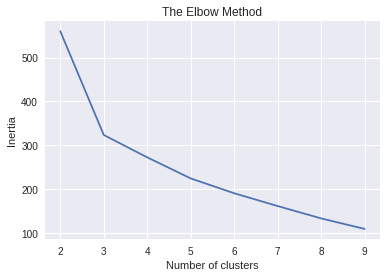

In [53]:
# Using the Elbow method to find the optimal number of clusters.
# By an elbow curve, where the x-axis represents the number of clusters and the y-axis is the evaluation metric.
# Create a kmeans function and fit it on the data 'X_clus'

inertias = []
for i in range (2, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 34, random_state = 0)
    kmeans.fit(X_clus)
    inertias.append(kmeans.inertia_)
plt.plot(range(2, 10), inertias)

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

As the above figure shows, there is an elbow at the 3rd cluster. However, the inertia value still reduced sharply after the 3rd cluster. Let's explore the clusters from the 2nd cluster.

In [54]:
# Applying k-means to 'X_clus' to 2 clusters
kmeans = KMeans(n_clusters = 2)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

kmeans.cluster_centers_

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0]


array([[ 5.33666667e-01, -1.10366667e-01,  5.27333333e-01,
         3.19600000e-01,  3.70566667e-01,  2.04100000e-01,
         2.29100000e-01,  9.20000000e-03,  3.79700000e-01],
       [-4.21000000e-01,  6.83350000e+00, -2.05250000e-01,
         1.03750000e-01,  9.22500000e-01,  7.80000000e-02,
        -5.00000000e-03,  6.34600000e+00, -1.90000000e-02]])

In [55]:
kmeans.inertia_

560.0842568666667

Inertia calculates the sum of distances of all the points within a cluster from the centroid of that cluster. The lesser the inertia value, the better our clusters are.

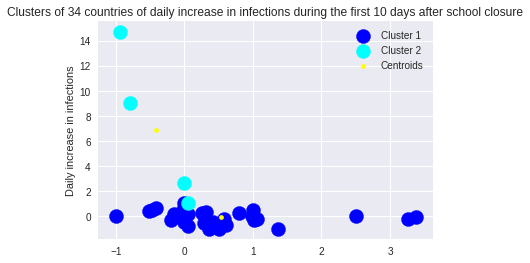

In [56]:
# Visualising the 2 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

In [57]:
# Applying k-means to 'X_clus' to 3 clusters
kmeans = KMeans(n_clusters = 3)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

kmeans.cluster_centers_

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0]


array([[ 0.51825806, -0.07454839,  0.50267742,  0.34377419,  0.3483871 ,
         0.19751613,  0.19654839,  0.22754839,  0.36193548],
       [-0.87      , 11.8335    , -0.0645    , -0.216     ,  1.039     ,
         0.5705    ,  0.8085    ,  0.803     ,  0.214     ],
       [ 0.        ,  2.667     , -0.455     , -0.222     ,  1.929     ,
        -0.829     , -0.857     , 17.        , -0.333     ]])

In [58]:
kmeans.inertia_

323.26495612903227

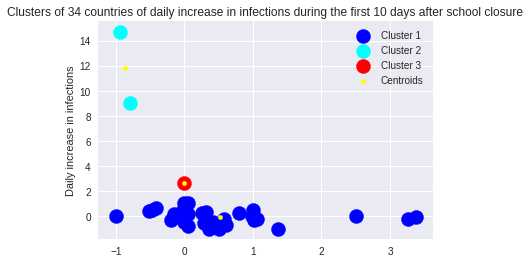

In [59]:
# Visualising the 3 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_clus[y == 2, 0], X_clus[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

In [60]:
# Applying k-means to 'X_clus' to 4 clusters
kmeans = KMeans(n_clusters = 4)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

kmeans.cluster_centers_

[1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 3 2 1 1 1 1 1 1 1 1 1 1]


array([[ 0.326     , -0.7685    ,  5.25      ,  0.0585    ,  1.1005    ,
         0.324     , -0.1135    ,  0.0775    ,  0.577     ],
       [ 0.53151724, -0.02668966,  0.17527586,  0.36344828,  0.29651724,
         0.1887931 ,  0.21793103,  0.23789655,  0.34710345],
       [ 0.        ,  2.667     , -0.455     , -0.222     ,  1.929     ,
        -0.829     , -0.857     , 17.        , -0.333     ],
       [-0.87      , 11.8335    , -0.0645    , -0.216     ,  1.039     ,
         0.5705    ,  0.8085    ,  0.803     ,  0.214     ]])

In [61]:
kmeans.inertia_

272.2035641551724

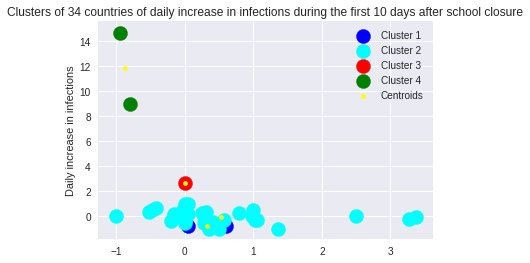

In [62]:
# Visualising the 4 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_clus[y == 2, 0], X_clus[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')
plt.scatter(X_clus[y == 3, 0], X_clus[y == 3, 1], s = 200, c = 'green', label = 'Cluster 4')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

In [63]:
# Applying k-means to 'X_clus' to 5 clusters
kmeans = KMeans(n_clusters = 5)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

kmeans.cluster_centers_

[0 0 0 0 3 2 0 0 3 0 0 0 3 0 0 0 3 3 3 0 3 0 2 4 0 0 0 3 0 0 0 3 1 0]


array([[ 3.85666667e-01,  5.00476190e-02, -6.55238095e-02,
         3.87619048e-01,  4.89571429e-01,  3.22380952e-02,
         4.02476190e-01, -3.80952381e-03,  1.32619048e-01],
       [ 5.60000000e-02,  1.00000000e+00, -2.37000000e-01,
         1.06900000e+00, -3.17000000e-01,  0.00000000e+00,
        -7.80000000e-01,  6.77800000e+00, -1.71000000e-01],
       [-8.70000000e-01,  1.18335000e+01, -6.45000000e-02,
        -2.16000000e-01,  1.03900000e+00,  5.70500000e-01,
         8.08500000e-01,  8.03000000e-01,  2.14000000e-01],
       [ 8.79000000e-01, -4.84666667e-01,  1.91066667e+00,
         1.60888889e-01,  9.28888889e-02,  6.05111111e-01,
        -1.75444444e-01,  3.95555556e-02,  9.56222222e-01],
       [ 0.00000000e+00,  2.66700000e+00, -4.55000000e-01,
        -2.22000000e-01,  1.92900000e+00, -8.29000000e-01,
        -8.57000000e-01,  1.70000000e+01, -3.33000000e-01]])

In [64]:
kmeans.inertia_

236.91639485714285

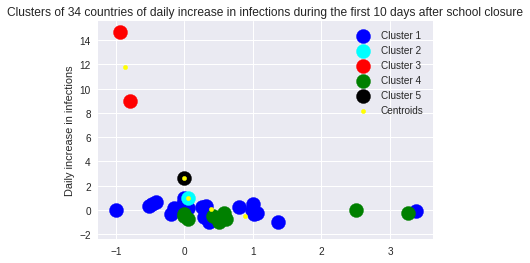

In [65]:
# Visualising the 5 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_clus[y == 2, 0], X_clus[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')
plt.scatter(X_clus[y == 3, 0], X_clus[y == 3, 1], s = 200, c = 'green', label = 'Cluster 4')
plt.scatter(X_clus[y == 4, 0], X_clus[y == 4, 1], s = 200, c = 'black', label = 'Cluster 5')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

In [66]:
# Applying k-means to 'X_clus' to 6 clusters
kmeans = KMeans(n_clusters = 6)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

[0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 4 0 0 0 4 0 5 1 0 0 0 0 0 0 0 0 2 0]


In [67]:
# inertia on the fitted data for 6 clusters
kmeans.inertia_

194.9417646428571

In [68]:
# The centers of 6 clusters
kmeans.cluster_centers_

array([[ 5.48500000e-01, -6.33571429e-02,  1.90000000e-01,
         3.38250000e-01,  3.18428571e-01,  1.95535714e-01,
         2.53571429e-01,  4.32142857e-03,  3.65607143e-01],
       [ 0.00000000e+00,  2.66700000e+00, -4.55000000e-01,
        -2.22000000e-01,  1.92900000e+00, -8.29000000e-01,
        -8.57000000e-01,  1.70000000e+01, -3.33000000e-01],
       [ 5.60000000e-02,  1.00000000e+00, -2.37000000e-01,
         1.06900000e+00, -3.17000000e-01,  0.00000000e+00,
        -7.80000000e-01,  6.77800000e+00, -1.71000000e-01],
       [-9.40000000e-01,  1.46670000e+01,  2.10000000e-02,
         3.33000000e-01, -2.97000000e-01,  1.17800000e+00,
        -3.06000000e-01,  2.38200000e+00, -3.96000000e-01],
       [ 3.26000000e-01, -7.68500000e-01,  5.25000000e+00,
         5.85000000e-02,  1.10050000e+00,  3.24000000e-01,
        -1.13500000e-01,  7.75000000e-02,  5.77000000e-01],
       [-8.00000000e-01,  9.00000000e+00, -1.50000000e-01,
        -7.65000000e-01,  2.37500000e+00, -3.700000

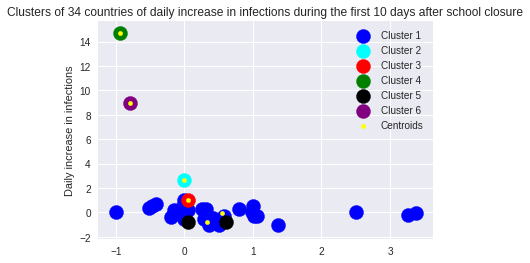

In [69]:
# Visualising the 6 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_clus[y == 2, 0], X_clus[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')
plt.scatter(X_clus[y == 3, 0], X_clus[y == 3, 1], s = 200, c = 'green', label = 'Cluster 4')
plt.scatter(X_clus[y == 4, 0], X_clus[y == 4, 1], s = 200, c = 'black', label = 'Cluster 5')
plt.scatter(X_clus[y == 5, 0], X_clus[y == 5, 1], s = 200, c = 'purple', label = 'Cluster 6')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

In [70]:
# Applying k-means to 'X_clus' to 7 clusters
kmeans = KMeans(n_clusters = 7)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

kmeans.cluster_centers_

[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 6 1 6 1 6 1 5 2 1 1 1 6 1 1 1 4 3 1]


array([[-9.4000e-01,  1.4667e+01,  2.1000e-02,  3.3300e-01, -2.9700e-01,
         1.1780e+00, -3.0600e-01,  2.3820e+00, -3.9600e-01],
       [ 5.9748e-01, -1.7640e-02,  4.2160e-02,  3.7348e-01,  3.9912e-01,
         2.4656e-01,  2.9188e-01,  5.0840e-02,  1.3964e-01],
       [ 0.0000e+00,  2.6670e+00, -4.5500e-01, -2.2200e-01,  1.9290e+00,
        -8.2900e-01, -8.5700e-01,  1.7000e+01, -3.3300e-01],
       [ 5.6000e-02,  1.0000e+00, -2.3700e-01,  1.0690e+00, -3.1700e-01,
         0.0000e+00, -7.8000e-01,  6.7780e+00, -1.7100e-01],
       [ 4.2100e-01, -4.8900e-01,  7.4000e-02,  8.1000e-02, -1.1300e-01,
        -3.9100e-01, -3.9900e-01, -7.8700e-01,  5.9140e+00],
       [-8.0000e-01,  9.0000e+00, -1.5000e-01, -7.6500e-01,  2.3750e+00,
        -3.7000e-02,  1.9230e+00, -7.7600e-01,  8.2400e-01],
       [ 1.6300e-01, -5.9525e-01,  3.6730e+00,  4.2500e-02,  3.1300e-01,
         8.7500e-02, -6.2500e-03, -5.2000e-02,  4.9650e-01]])

In [71]:
kmeans.inertia_

163.09685866

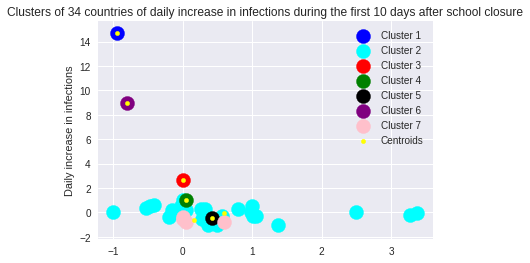

In [72]:
# Visualising the 7 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_clus[y == 2, 0], X_clus[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')
plt.scatter(X_clus[y == 3, 0], X_clus[y == 3, 1], s = 200, c = 'green', label = 'Cluster 4')
plt.scatter(X_clus[y == 4, 0], X_clus[y == 4, 1], s = 200, c = 'black', label = 'Cluster 5')
plt.scatter(X_clus[y == 5, 0], X_clus[y == 5, 1], s = 200, c = 'purple', label = 'Cluster 6')
plt.scatter(X_clus[y == 6, 0], X_clus[y == 6, 1], s = 200, c = 'pink', label = 'Cluster 7')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

In [73]:
# Applying k-means to 'X_clus' to 9 clusters
kmeans = KMeans(n_clusters = 9)

# Fitting
y = kmeans.fit_predict(X_clus)

# Prediction
prediction = kmeans.predict(X_clus)
print(prediction)

kmeans.cluster_centers_

[0 0 0 0 8 1 0 0 0 0 0 0 5 0 0 0 5 0 5 0 6 0 7 2 0 5 0 5 0 0 5 4 3 0]


array([[ 6.67809524e-01, -1.82857143e-02, -5.22380952e-02,
         4.21285714e-01,  2.08571429e-01,  9.16190476e-02,
         3.39761905e-01,  1.09523810e-01,  6.54285714e-02],
       [-9.40000000e-01,  1.46670000e+01,  2.10000000e-02,
         3.33000000e-01, -2.97000000e-01,  1.17800000e+00,
        -3.06000000e-01,  2.38200000e+00, -3.96000000e-01],
       [ 0.00000000e+00,  2.66700000e+00, -4.55000000e-01,
        -2.22000000e-01,  1.92900000e+00, -8.29000000e-01,
        -8.57000000e-01,  1.70000000e+01, -3.33000000e-01],
       [ 5.60000000e-02,  1.00000000e+00, -2.37000000e-01,
         1.06900000e+00, -3.17000000e-01,  0.00000000e+00,
        -7.80000000e-01,  6.77800000e+00, -1.71000000e-01],
       [ 4.21000000e-01, -4.89000000e-01,  7.40000000e-02,
         8.10000000e-02, -1.13000000e-01, -3.91000000e-01,
        -3.99000000e-01, -7.87000000e-01,  5.91400000e+00],
       [ 1.68833333e-01, -1.08500000e-01,  1.64050000e+00,
         2.16666667e-02,  1.17216667e+00, -4.883333

In [74]:
kmeans.inertia_

116.18739773809523

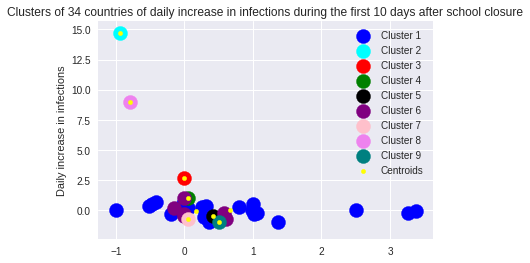

In [75]:
# Visualising the 9 clusters

# Create a scatter plot
plt.scatter(X_clus[y == 0, 0], X_clus[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_clus[y == 1, 0], X_clus[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_clus[y == 2, 0], X_clus[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')
plt.scatter(X_clus[y == 3, 0], X_clus[y == 3, 1], s = 200, c = 'green', label = 'Cluster 4')
plt.scatter(X_clus[y == 4, 0], X_clus[y == 4, 1], s = 200, c = 'black', label = 'Cluster 5')
plt.scatter(X_clus[y == 5, 0], X_clus[y == 5, 1], s = 200, c = 'purple', label = 'Cluster 6')
plt.scatter(X_clus[y == 6, 0], X_clus[y == 6, 1], s = 200, c = 'pink', label = 'Cluster 7')
plt.scatter(X_clus[y == 7, 0], X_clus[y == 7, 1], s = 200, c = 'violet', label = 'Cluster 8')
plt.scatter(X_clus[y == 8, 0], X_clus[y == 8, 1], s = 200, c = 'teal', label = 'Cluster 9')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clusters of 34 countries of daily increase in infections during the first 10 days after school closure')
plt.ylabel('Daily increase in infections')
plt.legend()
plt.show()

(-1.2304494026284347,
 3.6094494026284343,
 -1.8010560338484178,
 15.468056033848416)

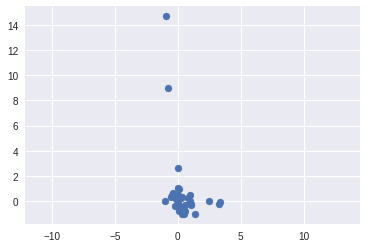

In [76]:
# visualize the dataset X_clus
plt.scatter(X_clus[:, 0], X_clus[:, 1])
plt.axis('equal')

In [77]:
# Scaling the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clus)
# Normalizing the Data
X_nor = normalize(X_scaled)
# Converting the numpy array into a pandas DataFrame
X_nor_df = pd.DataFrame(X_nor)
X_nor_df

,0,1,2,3,4,5,6,7,8
0,0.412379,-0.173963,-0.137776,-0.269489,-0.199445,0.465919,-0.040505,-0.196742,-0.640988
1,-0.775054,-0.056316,-0.343439,-0.257946,-0.096610,0.074996,0.349918,-0.151504,-0.226451
2,-0.050205,-0.065056,-0.352887,-0.281808,0.728348,-0.310711,0.213229,-0.147637,-0.308232
3,0.188785,-0.022759,-0.109459,0.928969,-0.244515,0.027768,-0.046282,-0.089186,-0.134990
4,0.014244,-0.104382,-0.055482,0.138417,-0.199264,0.907273,-0.298105,-0.043514,-0.114255
5,-0.262582,0.909394,-0.056275,0.010161,-0.129056,0.198588,-0.134109,0.099922,-0.129311
6,-0.148982,-0.136132,-0.170647,-0.235985,-0.634657,-0.208894,-0.511700,0.237884,-0.331076
7,-0.528941,-0.012124,-0.514867,0.416995,0.001449,-0.211012,0.085591,-0.222408,0.424006
8,0.953689,-0.104758,0.004388,0.053154,-0.219645,0.018753,-0.112275,-0.092683,-0.082867
9,-0.511990,-0.062605,-0.047920,-0.252213,-0.236224,-0.084357,0.750487,-0.192942,-0.068295


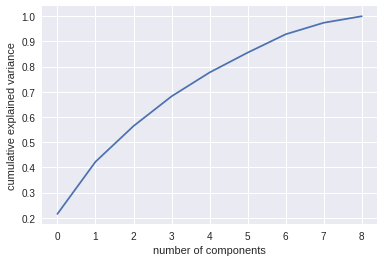

In [78]:
pca = PCA().fit(X_nor_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the above curve, we see that the first 2 components contain approximately 55% of the variance, the first 3 components contain approximately 69% of the variance, in order to describe 100% of the variance, we need 8 components. For visualization, we have to select the components equal or less than 3. 

In [79]:
# Reducing the dimensions of the data to components=2
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_nor_df)
X_pca.shape

(34, 2)

In [80]:
# create a dataframe for 2 principals
X_principal = pd.DataFrame(X_pca)
X_principal.columns = ['Principal_1', 'Principal_2']
X_principal

,Principal_1,Principal_2
0,0.526286,0.043980
1,-0.805276,0.043407
2,-0.250364,-0.500766
3,0.212856,0.749268
4,0.265632,0.487133
5,-0.240436,0.369851
6,0.186576,0.486419
7,-0.658772,0.305030
8,0.934631,-0.052955
9,-0.701378,-0.242362


In [81]:
!pip install mglearn

/opt/conda/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'Second principal component')

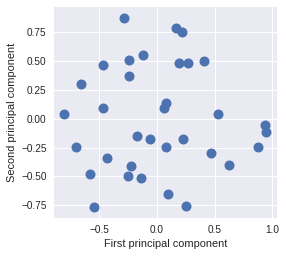

In [82]:
# plot first vs. second principal component
import mglearn
plt.figure(figsize=(4, 5))
X_prin = np.array(X_principal)
mglearn.discrete_scatter(X_prin[:, 0], X_prin[:, 1])
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

(-0.9044951466008674,
 1.0483270602839143,
 -0.870286870305359,
 0.9784371012252656)

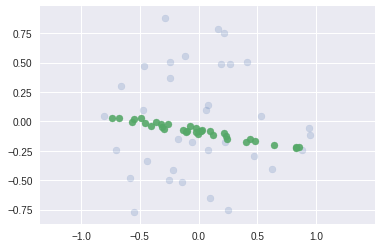

In [83]:
# Reversing the transformation and plotting
X_reverse = pca.inverse_transform(X_pca)
plt.scatter(X_prin[:, 0], X_prin[:, 1], alpha=0.2)
plt.scatter(X_reverse[:, 0], X_reverse[:, 1], alpha=0.9)
plt.axis('equal')

The light grey points are the original data, while the dark green points are the projected version. Reversing the transformation makes a PCA dimensionality reduction. The information along the most important principal axes is keeped; the information along the less important principal axes is removed. Despite reducing the dimension of the data information, the overall relationship between the data points are mostly preserved.

In [84]:
# The shapes before and after PCA projection from 9 to 2 dimensions
pca = PCA(2) 
projected = pca.fit_transform(X_nor.data)
print(X_nor.shape)
print(projected.shape)

(34, 9)
(34, 2)


In [85]:
# The 2 components after PCA
print(pca.components_)

[[ 0.88224508 -0.13648171  0.13185474 -0.00900087 -0.12534711  0.1064235
  -0.3599368   0.11762159 -0.12297344]
 [-0.26022516  0.07933365 -0.156909    0.66244916 -0.42720435  0.1655105
  -0.40455449  0.17491306 -0.24160614]]


In [86]:
pca.explained_variance_ratio_

array([0.21494972, 0.20703796])

The first PCA explains 21.5% information. The second PCA explain 20.7% information.

In [87]:
pca.explained_variance_ratio_.sum()

0.42198767990916775

After only two-dimensional projection, it loses 58% information of the dataset.

In [88]:
# convert dataframe to array vector
X_prin = np.array(X_principal)
X_prin

array([[ 0.52628603,  0.04397951],
       [-0.8052765 ,  0.04340716],
       [-0.25036372, -0.50076606],
       [ 0.21285649,  0.7492679 ],
       [ 0.26563188,  0.48713309],
       [-0.24043562,  0.36985108],
       [ 0.1865756 ,  0.48641904],
       [-0.65877241,  0.30503037],
       [ 0.93463058, -0.05295481],
       [-0.7013783 , -0.24236181],
       [-0.46932374,  0.0958407 ],
       [-0.28582635,  0.8783078 ],
       [ 0.09707548, -0.65130548],
       [-0.43846191, -0.33728569],
       [ 0.62421129, -0.40245113],
       [-0.11790847,  0.55696469],
       [ 0.22563306, -0.17479065],
       [ 0.94910841, -0.11501093],
       [ 0.06145549,  0.09695191],
       [-0.24544915,  0.50597865],
       [ 0.08130836, -0.24532045],
       [-0.14290354, -0.51761518],
       [-0.58496348, -0.48021294],
       [ 0.07573787,  0.13933964],
       [ 0.25174149, -0.75430325],
       [-0.55015562, -0.77015757],
       [ 0.41154627,  0.50367698],
       [-0.17478707, -0.14892545],
       [-0.46697179,

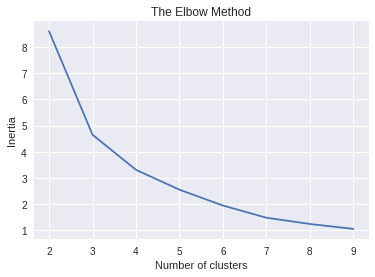

In [89]:
# Using the Elbow method to find the optimal number of clusters.
# By an elbow curve, where the x-axis represents the number of clusters and the y-axis is the evaluation metric.
# Create a kmeans function and fit it on the data 'X_prin'
inertias = []
for i in range (2, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 34, random_state = 0)
    kmeans.fit(X_prin)
    inertias.append(kmeans.inertia_)
plt.plot(range(2, 10), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The optimal number of clusters could be k=7. However, we could plot k=3 also, in order to see its kmeans.inertia value.

In [90]:
# Applying k-means to 'X_prin' to 3 clusters
kmeans = KMeans(n_clusters = 3)

# Fitting
y = kmeans.fit_predict(X_prin)

# Prediction
prediction = kmeans.predict(X_prin)
print(prediction)

kmeans.cluster_centers_

[0 2 2 1 1 1 1 1 0 2 2 1 2 2 0 1 0 0 1 1 2 2 2 1 0 2 1 2 1 0 2 2 1 0]


array([[ 0.6074847 , -0.24941411],
       [-0.04914455,  0.48750523],
       [-0.32469218, -0.33401963]])

In [91]:
kmeans.inertia_

4.6471414101261965

This result "4.65" (after PCA clustering) is much better than the inertia value "323" for 3 clusters before PCA.

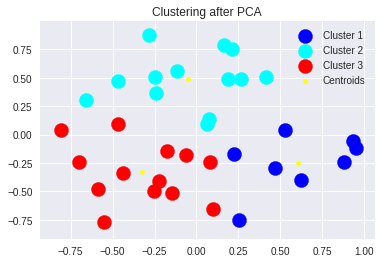

In [92]:
# Visualising the 3 clusters
# Create a scatter plot
plt.scatter(X_prin[y == 0, 0], X_prin[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_prin[y == 1, 0], X_prin[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_prin[y == 2, 0], X_prin[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clustering after PCA')
plt.legend()
plt.show()

In [93]:
# Applying k-means to 'X_prin' to 7 clusters
kmeans = KMeans(n_clusters = 7)

# Fitting
y = kmeans.fit_predict(X_prin)

# Prediction
prediction = kmeans.predict(X_prin)
print(prediction)

kmeans.cluster_centers_

[0 5 1 3 3 2 3 5 0 5 5 2 6 1 0 2 4 0 4 2 4 1 1 4 6 1 3 4 2 0 1 4 3 0]


array([[ 0.73041717, -0.17770316],
       [-0.36473901, -0.50270654],
       [-0.27131828,  0.55596792],
       [ 0.24785825,  0.6032813 ],
       [ 0.03486087, -0.08501594],
       [-0.65868774,  0.05047911],
       [ 0.17440848, -0.70280436]])

In [94]:
kmeans.inertia_

1.4484909898067717

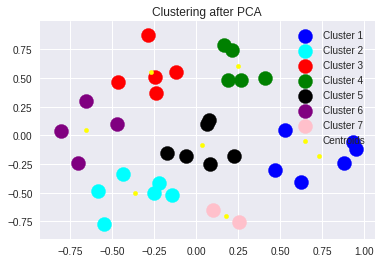

In [95]:
# Visualising the 7 clusters
# Create a scatter plot
plt.scatter(X_prin[y == 0, 0], X_prin[y == 0, 1], s = 200, c = 'blue', label = 'Cluster 1')
plt.scatter(X_prin[y == 1, 0], X_prin[y == 1, 1], s = 200, c = 'cyan', label = 'Cluster 2')
plt.scatter(X_prin[y == 2, 0], X_prin[y == 2, 1], s = 200, c = 'red', label = 'Cluster 3')
plt.scatter(X_prin[y == 3, 0], X_prin[y == 3, 1], s = 200, c = 'green', label = 'Cluster 4')
plt.scatter(X_prin[y == 4, 0], X_prin[y == 4, 1], s = 200, c = 'black', label = 'Cluster 5')
plt.scatter(X_prin[y == 5, 0], X_prin[y == 5, 1], s = 200, c = 'purple', label = 'Cluster 6')
plt.scatter(X_prin[y == 6, 0], X_prin[y == 6, 1], s = 200, c = 'pink', label = 'Cluster 7')

# Asign the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

# Plotting clusters
plt.title('Clustering after PCA')
plt.legend()
plt.show()

### Conclusion

Although after only two-dimensional projection, the datas explain only 42% information of the dataset. However, the noisy datas are deleted after PCA. After PCA, the datas are better identified by clusters.

Inertia calculates the sum of distances of all the points within a cluster from the centroid of that cluster. The lesser the inertia value, the better clusters are. Before PCA, the inertia value with 2 clusters is 560, with 3 clusters is 323, with 5 clusters is 245, with 7 clusters is 166, with 9 clusters is 110. After PCA, the inertia value with 3 clusters is only 4.65, with 7 clusters is only 1.49.

References: 
    1. The database of "COVID-19 Impact on Education", UNESCO, https://en.unesco.org/covid19/educationresponse
    2. "Map: Coronavirus and School Closures", Education Week, https://www.edweek.org/ew/section/multimedia/map-coronavirus-and-school-closures.html
    3. "China population", worldometer, https://www.worldometers.info/world-population/china-population/
    4. "Hubei population", World population net, https://www.renkou.org.cn/china/hubei/